# **Analytics for Unstructured Data - Assignment 1**

By - 
Ramya Desineedi, Neha Dipali, MC Kreps, Soumya Nayak, Walter Wu

## **Web Scraping from Edmunds - Extracting early 10,000 posts from the thread**

Forum Used - https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p1

In [ ]:
# Use this code if using Colab to run Selenium

# Make sure to go to Runtime -> Change runtime and set GPU as hardware accelerator

# !kill -9 -1 # Use this line to delete this VM and start a new one. 
# The above line deletes all files and folders from the current VM and allocates a new one.

import pandas as pd

#Selenium is an open-source tool that automates web browsers.
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver 
#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

     |████████████████████████████████| 904 kB 5.4 MB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.4 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security

In [ ]:
driver = webdriver.Chrome('chromedriver',options=chrome_options)

webpage_base = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'

comments_final = pd.DataFrame(columns = ['Date','user_id','comments']) 

for i in range(200):
  webpage = webpage_base+str(i+1)
  driver.get(webpage)
  
  comments = pd.DataFrame(columns = ['Date','user_id','comments']) 
  ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
  comment_ids = []

  for i in ids:
      comment_ids.append(i.get_attribute('id'))


  for x in comment_ids:
      #Extract dates from for each user on a page
      user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
      date = user_date.get_attribute('title')

      #Extract user ids from each user on a page
      userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
      userid = userid_element.text

      #Extract Message for each user on a page
      user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
      comment = user_message.text
                                    
      #Adding date, userid and comment for each user in a dataframe    
      comments.loc[len(comments)] = [date,userid,comment]
  comments_final = comments_final.append(comments)

WebDriverException: ignored

In [ ]:
comments_final.head()

Backing up raw dataset to local computer

In [ ]:
comments_final.to_csv("AUD Assignment 1 - Raw Data.csv")
!ls
from google.colab import files
files.download("AUD Assignment 1 - Raw Data.csv")

## **Task A: Testing Zipf's Law**

### Initialization - to access file from Google Drive

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#https://drive.google.com/file/d/1kF1Q8MEyvFmgBN117OLnocT3-t-yIC6d/view?usp=sharing - location of the raw data saved
fileDownloaded = drive.CreateFile({'id':'1kF1Q8MEyvFmgBN117OLnocT3-t-yIC6d'})
fileDownloaded.GetContentFile('raw_data.csv')

In [ ]:
import pandas as pd
raw_data = pd.read_csv('raw_data.csv') #read data from csv
raw_data = raw_data[["Date","user_id","comments"]]
raw_data.head()

,Date,user_id,comments
0,"March 24, 2002 10:54PM",merc1,I personally think that with a few tweaks the ...
1,"March 25, 2002 12:06AM",fredvh,I am debating a new purchase and these two are...
2,"March 25, 2002 10:02AM",blueguydotcom,"Great handling, RWD, excellent engine and the ..."
3,"March 25, 2002 4:04PM",hungrywhale,And no manual tranny. That may not matter to y...
4,"March 25, 2002 5:44PM",riez,One beauty of BMW 3 Series is that there are s...


###Word-wise frequency count (stopwords included)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Text(0, 0.5, 'log(Frequency)')

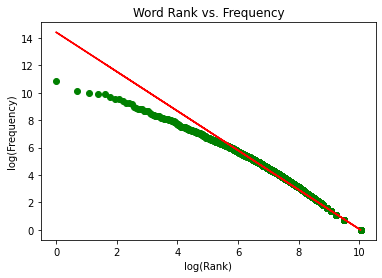

In [ ]:
import nltk as nltk
from nltk import word_tokenize
from nltk import TreebankWordTokenizer
from nltk.corpus import reuters
from nltk.corpus import wordnet
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
nltk.download('punkt')
nltk.download('stopwords')

tokenizer = TreebankWordTokenizer()

df = raw_data

tokenized = []

comments = []
for i in df['comments']: #put comments in list.
    comments.append(i)

import re
import string

table = str.maketrans('','', string.punctuation) #remove punctuation

def tokenized(x):
    return word_tokenize(x) #function that toknize words in df

def no_punc(x):
    return x.translate(table) #function that removes punctuation in df

def lower(x):
    return x.lower() #function that turns all to lower case in df

df['comments'] = df['comments'].apply(str).map(lower).map(no_punc).apply(str) #make comments into lower case tokenized words without punctuations

df['comments_token'] = df['comments'].map(tokenized)
df_X = df.copy()

word_set = [] #Putting all the words into a list

for i in range(10000):
    for a in range(len(df['comments_token'][i])):
        word_set.append(df['comments_token'][i][a])

df_word = pd.DataFrame(columns = ['word'])
import numpy as np

df_word['word'] = np.array(word_set) 

count = df_word['word'].value_counts() #Get the count for each word

def get_count(x):
    return count[x]

df_word['count'] = df_word['word'].map(get_count)

#Add rank column for each word based on frequency
df_word_2 = df_word.copy()
df_word_2 = df_word_2.drop_duplicates(subset = ['word'])
df_word_2['rank'] = df_word_2['count'].rank(ascending = False)

count_rank = count[:100]
total = 0
counter = 0

for i in range(99):
    k = i + 1
    while k < 99:
        value = count_rank[i]/count_rank[k]
        value2 = (k+1)/(i+1)
        total += (value/value2)
        k+=1
        counter += 1
        
df_zipf = df_word_2.copy()

def get_log(x):
    return math.log(x) #copy the data frame to do the df_zipf law in order to avoiding changing stuff in previews df.

df_zipf['log_count'] = df_zipf['count'].map(get_log)
df_zipf['log_rank'] = df_zipf['rank'].map(get_log)
#put log rank and count into the new data frame
#plotting, log rank vs. log count with a fitting line.
plt.plot(df_zipf['log_rank'], df_zipf['log_count'], 'o', color='green')
m, b = np.polyfit(df_zipf['log_rank'], df_zipf['log_count'], 1)
plt.plot(df_zipf['log_rank'], m*df_zipf['log_rank']+b, color='red')
plt.title('Word Rank vs. Frequency')
plt.xlabel('log(Rank)')
plt.ylabel('log(Frequency)')

0.913900970476037is the average of ratio of count i / count k over rank k / rank i


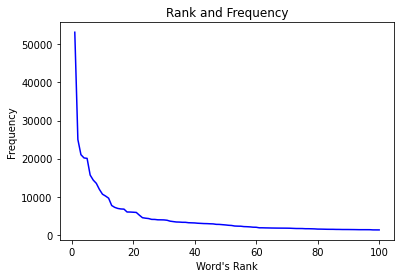

In [ ]:
df_100 = df_zipf[df_zipf['rank'] <= 100]
df_100 = df_100.sort_values(by = ['rank'])
plt.plot(df_100['rank'], df_100['count'], '-', color='blue')
plt.title('Rank and Frequency')
plt.xlabel("Word's Rank")
plt.ylabel('Frequency')

print(str(total/counter) + 'is the average of ratio of count i / count k over rank k / rank i') 

Considering the 100 words occurring most often, we observe that there are a few words which are repeated with a very high frequency, such as "a", "and", "the", "to", "i" (more than 20,000 instances among the 10000 comments scraped). By the time we reach the 100th most common word, it is observed that the frequency drops to only 1288. This supports Zipf's Law

## **Task B: Top 10 Brands from Frequency Counts (after excluding stopwords)**

In [ ]:
# Remove stopwords

from nltk.corpus import stopwords

df_word_3=[]

stop_words=set(stopwords.words("english"))
for w in df_word['word']:
    if w not in stop_words:
        df_word_3.append(w)
df_word_3[:10]

['personally',
 'think',
 'tweaks',
 'c320',
 'could',
 'also',
 'sit',
 'top',
 'group',
 'still']

In [ ]:
# df_word_filtered contains all the words except the stopwords

df_word_filtered = pd.DataFrame(columns = ['word'])
df_word_filtered['word'] = np.array(df_word_3)

fileDownloaded1 = drive.CreateFile({'id':'1ONH_n17lop9VrKcFnzmqginB4_DdiONa'})
fileDownloaded1.GetContentFile('car_models_and_brands.csv')

df_mapping = pd.read_csv('car_models_and_brands.csv')
df_mapping.head()

In [ ]:

# Replace frequently occurring car models with brands
# Replace all the car model with card brands from df_word_filtered and assign the transformed list to df_word_filtered1 


#Create the dictionary for mapping

df_mapping1 = df_mapping.set_index(['Model'])["Brand"].to_dict()

import re

def multiwordReplace(text, wordDict):
    
    for key in wordDict:
        text = text.replace(key, wordDict[key])
    return text


# the dictionary has target_word : replacement_word pairs
wordDict = df_mapping1

# call the function and get the changed text
str2 = multiwordReplace(df_word_filtered['word'], wordDict)

df_word_filtered1 = pd.DataFrame(columns = ['word'])
df_word_filtered1['word'] = np.array(str2)

In [ ]:
# Calculate frequency count from df_word_filtered1

count = df_word_filtered1['word'].value_counts()
def get_count(x):
    return count[x]
df_word_filtered1 = df_word_filtered1.drop_duplicates(subset="word")
df_word_filtered1['count'] = df_word_filtered1['word'].map(get_count)
# df_word_filtered1 = df_word_filtered1.drop_duplicates()
len(df_word_filtered1)

29980

In [ ]:
#Checkpoint - Saving the data with frequency counts after removing stopwords
df_word_filtered1.to_csv("Word Frequencies - After removing stopwords.csv")
!ls
from google.colab import files
files.download("Word Frequencies - After removing stopwords.csv")

In [ ]:
# Filter the data by the list of the brands (assigned to df_word_filtered2) and sort to find the top 10 brands 

list1 = list(df_mapping["Brand"].drop_duplicates())

df_word_filtered2 = df_word_filtered1[df_word_filtered1['word'].isin(list1)]
df_word_filtered2 = df_word_filtered2.drop_duplicates(subset = ['word']).sort_values(by='count', ascending=False)
df_word_filtered2[:10]
df_Y = df_word_filtered2.copy()
top_ten_brands=df_word_filtered2[:10]

In [ ]:
len(df_word_filtered2)

26

In [ ]:
brands=top_ten_brands['word']

top_ten_brands


,word,count
104,bmw,6323
131,acura,4113
58,audi,1891
432,honda,1181
743,infiniti,931
198,toyota,892
1276,nissan,706
1934,volvo,625
2022,volkswagen,553
2932,subaru,472


## **Task C: Calculation of Lift Ratios for Associations between Top-10 Brands**

In [ ]:

i=0
replaced_df= raw_data.copy()
used_list=[]
lift_dict= {}
replaced_count_dict ={}

for brand in brands:
    for i in range((replaced_df.shape[0])):
        if type(replaced_df.loc[i,'comments'])==str: 
            user_comment=replaced_df.loc[i,'comments'].lower()
            if (brand.lower() in user_comment):
                if brand not in replaced_count_dict:
                    replaced_count_dict[brand] = 1
                else:
                    replaced_count_dict[brand] += 1

replaced_count_df = pd.DataFrame.from_dict(replaced_count_dict, orient='index', columns=['Frequency'])
top_ten_brands=replaced_count_df.sort_values(by=['Frequency'], ascending=False).head(10).index.to_list()

for name1 in top_ten_brands:
    for name2 in top_ten_brands:
        #if (name1 != name2) and (name2 not in used_list):
        i+=1
        lift_dict[i]=[]
        lift_dict[i].append(name1)
        lift_dict[i].append(name2)
    used_list.append(name1)

name1=[]
name2=[]
frequency=[]

for pair in lift_dict.values():
    name1.append(pair[0])
    name2.append(pair[1])
    frequency.append(0)
    
for i in range(len(name1)):
    for j in range((replaced_df.shape[0])):
        if type(replaced_df.loc[j,'comments']) == str: 
            user_comment=replaced_df.loc[j,'comments'].lower()
        if ((name1[i].lower() in user_comment) and (name2[i].lower() in user_comment)):
            num=frequency[i]+1
            frequency[i]=num              

pair_freq_df= pd.DataFrame(name1, columns = ['Name1'])
pair_freq_df["Name2"]=name2
pair_freq_df["Frequency"]=frequency



# Finding the lift ratio for each pair
samples = raw_data.shape[0]
lift_ratio_list  = []
for i in range((pair_freq_df.shape[0])):
    pair_freq = pair_freq_df.loc[i,'Frequency']
    brand1 = pair_freq_df.loc[i,'Name1']
    brand2 = pair_freq_df.loc[i,'Name2']
    #A_freq = top_ten_dict.get(brand1)
    A_freq = replaced_count_df.loc[brand1].to_numpy()
    #B_freq = top_ten_dict.get(brand2)
    B_freq = replaced_count_df.loc[brand2].to_numpy()
    lift_ratio = (samples*pair_freq)/(A_freq*B_freq)
    lift_ratio_list.append(lift_ratio)
    lift_ratio_list[:10]

pair_freq_df= pd.DataFrame(name1, columns = ['Brand 1'])
pair_freq_df["Brand 2"]=name2
pair_freq_df["Frequency"]=frequency 
pair_freq_df['Lift Ratio']=np.around(lift_ratio_list,4)
pair_freq_df.to_csv("lift_ratio.csv")

In [ ]:
#Showing top lift ratios
pair_freq_df[pair_freq_df["Brand 1"] != pair_freq_df["Brand 2"]].sort_values(by="Lift Ratio", ascending=False)[:15]

,Brand 1,Brand 2,Frequency,Lift Ratio
98,volkswagen,subaru,5,13.6986
89,subaru,volkswagen,5,13.6986
97,volkswagen,toyota,8,12.5490
79,toyota,volkswagen,8,12.5490
96,volkswagen,nissan,9,12.4138
69,nissan,volkswagen,9,12.4138
74,toyota,honda,106,10.9391
47,honda,toyota,106,10.9391
76,toyota,nissan,73,9.8715
67,nissan,toyota,73,9.8715


In [ ]:
!ls
from google.colab import files
files.download("lift_ratio.csv")

 adc.json		     raw_data.csv
 car_models_and_brands.csv   sample_data
 lift_ratio.csv		    'Word Frequencies - After removing stopwords.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Task D: Showing Brands on Multi-dimensional Scaling Map**

In [ ]:

all_lift_ratios = pair_freq_df
sim_matrix = all_lift_ratios.pivot(index='Brand 1', columns='Brand 2', values='Lift Ratio')
np.fill_diagonal(sim_matrix.to_numpy(), None)
# Dissimilarity matrix
dis_matrix = 1/sim_matrix
np.fill_diagonal(dis_matrix.to_numpy(), 0)
print("Lift Calculations for brands: ")
sim_matrix

Lift Calculations for brands: 


Brand 2,acura,audi,bmw,honda,infiniti,nissan,subaru,toyota,volkswagen,volvo
Brand 1,,,,,,,,,,
acura,NaN,3.2142,1.8760,4.2683,4.8187,3.1268,3.4990,2.2037,2.5543,3.2146
audi,3.2142,NaN,2.2236,1.6205,3.6547,1.5233,3.3009,1.9424,5.8902,4.3257
bmw,1.8760,2.2236,NaN,1.5066,2.2530,1.4417,1.4705,1.4771,3.0132,1.6398
honda,4.2683,1.6205,1.5066,NaN,1.7759,7.3503,2.7037,10.9391,5.2632,2.8643
infiniti,4.8187,3.6547,2.2530,1.7759,NaN,4.7599,3.2566,2.2254,4.2945,2.8692
nissan,3.1268,1.5233,1.4417,7.3503,4.7599,NaN,4.0151,9.8715,12.4138,3.6359
subaru,3.4990,3.3009,1.4705,2.7037,3.2566,4.0151,NaN,3.4918,13.6986,5.3583
toyota,2.2037,1.9424,1.4771,10.9391,2.2254,9.8715,3.4918,NaN,12.5490,2.8011
volkswagen,2.5543,5.8902,3.0132,5.2632,4.2945,12.4138,13.6986,12.5490,NaN,8.1633


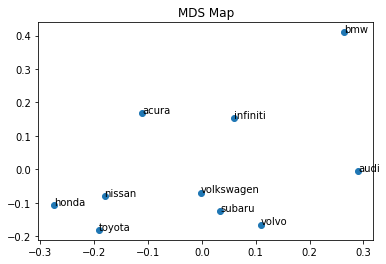

In [ ]:
from sklearn.manifold import MDS
mds = MDS(2,random_state=0,dissimilarity='precomputed')
dis_sim_2d_matrix = mds.fit_transform(dis_matrix) ##computes distances
data = pd.DataFrame(dis_sim_2d_matrix, columns=['x', 'y'], index = dis_matrix.index)
plt.scatter(data.x, data.y)
ax = plt.gca()

plt.title("MDS Map")
for index, x_val, y_val in data.itertuples():
    ax.annotate(index, (x_val, y_val))

**Clustering**

Text(0.5, 1.0, 'Clustering Output')

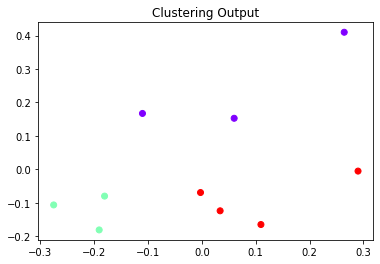

In [ ]:
kmeans = KMeans(3)
kmeans.fit(data)

identified_clusters = kmeans.fit_predict(data)
identified_clusters

data_with_clusters = data.copy()

data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['x'],data_with_clusters['y'],c=data_with_clusters['Clusters'],cmap='rainbow')
plt.title("Clustering Output")


## **Task E: Insights from task C and D**

High statistical lifts are observed between Nissan, Toyota and Honda as expected, implying that these brands have similar offerings and are considered to be close competitors. These brands are associated with economical options for quality and durability 

High lifts are also observed between Volkswagen, Toyota, Subaru, Nissan and Volvo as well. The KMeans clustering output places Volkswagen, Subaru, Volvo and Audi in the same cluster. Subaru and Volvo are synonymous with safety. 

BMW, Acura and Infiniti are the last cluster, indicating the luxury brands. It is rather surprising to see Audi not being a part of the luxury cluster.




## **Task F: Top 5 Attributes and their Association with Brands**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Count Word Frequency
word_freq = {}
for i in range((raw_data.shape[0])):
    if type(replaced_df.loc[i,'comments']) == str: 
        user_comment=replaced_df.loc[i,'comments'].lower()
        match_pattern = re.findall(r'\b[a-z]{3,15}\b', user_comment)
        for word in match_pattern:
            if word not in stop_words:
                count = word_freq.get(word,0)
                word_freq[word] = count + 1
                
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
#word_freq_df.sort_values(by=['Frequency'], ascending=False).head(10)

sorted=word_freq_df.sort_values(by=['Frequency'], ascending=False)
word_freq_df.to_csv("word_freq.csv")
sorted.to_csv("sorted_word_freq.csv")

attributes = ['performance','luxury', 'interior','price','transmission','suspension',
              'rwd','awd','handling','power','fwd','quality','sports','value','mileage',
              'torque','speed', 'reliability','steering','design']


# Looking through all the comments after the model names have been replaced by the brand names
attributes_count_dict ={}
for attribute in attributes:
    for i in range((replaced_df.shape[0])):
        if type(replaced_df.loc[i,'comments']) == str: 
            user_comment=replaced_df.loc[i,'comments'].lower()
        if (attribute.lower() in user_comment):
            if attribute not in attributes_count_dict:
                attributes_count_dict[attribute] = 1
            else:
                attributes_count_dict[attribute] += 1

In [ ]:
# Making the dictionary into a dataframe
attributes_count_df = pd.DataFrame.from_dict(attributes_count_dict, orient='index', columns=['Frequency'])
print("Top 5 attributes: ")
print(attributes_count_df.sort_values(by=['Frequency'], ascending=False).head(5))

top_five_attributes=attributes_count_df.sort_values(by=['Frequency'], ascending=False).head(5).index.to_list()

Top 5 attributes: 
             Frequency
performance       1306
price             1198
luxury            1063
power              997
interior           814


In [ ]:
# Creating a list that creates the pairs a brand with an atrribute name to find the frequency when both are mentioned at the same time in a comment
# performance bmw
# performance toyota
# performance acura

i= 0 
ba_lift_dict={}
ba_used_list=[]
for name1 in top_ten_brands:
    for name2 in top_five_attributes:
        i+=1
        ba_lift_dict[i] = []
        ba_lift_dict[i].append(name1)
        ba_lift_dict[i].append(name2)
    ba_used_list.append(name1)

pair_brand=[]
pair_attribute=[]
ba_freq=[]
for pair in ba_lift_dict.values():
    pair_brand.append(pair[0])
    pair_attribute.append(pair[1])
    ba_freq.append(0)

for i in range(len(pair_brand)):
    for j in range((replaced_df.shape[0])):
        if type(replaced_df.loc[j,'comments']) == str: 
            user_comment=replaced_df.loc[j,'comments'].lower()
            if ((pair_brand[i].lower() in user_comment) and (pair_attribute[i].lower() in user_comment)):
                num=ba_freq[i]+1
                ba_freq[i]=num

In [ ]:
# Creating a dataframe of the information
ba_pair_freq_df= pd.DataFrame(pair_brand, columns = ['Brand'])
ba_pair_freq_df["Attribute"]=pair_attribute
ba_pair_freq_df["Frequency"]=ba_freq

# Finding the lift ratio for each pair
samples = raw_data.shape[0]
ba_lift_ratio_list = []
for i in range((ba_pair_freq_df.shape[0])):
    pair_freq = ba_pair_freq_df.loc[i,'Frequency']
    brand_pair = ba_pair_freq_df.loc[i,'Brand']
    attribute_pair = ba_pair_freq_df.loc[i,'Attribute']
    A_freq = replaced_count_df.loc[brand_pair].to_numpy()[0]
    B_freq = attributes_count_df.loc[attribute_pair].to_numpy()[0]
    ba_lift_ratio = (samples*pair_freq)/(A_freq*B_freq)
    ba_lift_ratio_list.append(ba_lift_ratio)
    
# Creating a dataframe that shows the two brand names and their lift ratio
ba_lift_ratio_df= pd.DataFrame(pair_brand, columns = ['Brand'])
ba_lift_ratio_df["Attribute"]=pair_attribute
ba_lift_ratio_df["Lift Ratio"]=ba_lift_ratio_list

In [ ]:
ba_lift_ratio_df.pivot_table(values='Lift Ratio', index="Brand", columns="Attribute")

Attribute,interior,luxury,performance,power,price
Brand,,,,,
acura,1.757243,2.294766,1.770002,1.780565,1.705695
audi,2.664220,1.826056,1.455541,2.054356,1.620282
bmw,1.415900,1.470450,1.511206,1.601792,1.625433
honda,1.066856,2.054761,1.390344,2.032413,1.581583
infiniti,1.903046,1.904553,1.655878,1.476823,1.779551
nissan,1.482674,1.362442,1.346570,2.075191,1.208911
subaru,1.851166,3.221691,1.520905,2.060977,1.600842
toyota,1.156236,2.176600,1.141038,1.219344,1.374840
volkswagen,0.982801,4.139229,0.918836,3.610832,2.671119


## **Task G: Insights from Task F**



At a cluster level, our observations are as follows – 

- In case of the cluster having Acura, Infiniti and BMW, Acura was most likely to be associated with luxury, performance, and power. Infiniti was likely to be known for its price and interiors. BMW on the other hand was the most mentioned brand in the corpus of comments – considering that it had high confidence, it was not surprising that its lifts with the attributes were relatively lower compared to the other brands

- In case of the cluster having Audi, Volkswagen, Subaru and Volvo, Volkswagen was found to be most likely to be associated with luxury, power, and price; while Audi was most likely to be associated with interiors

- Considering the cluster having the Japanese brands of Honda, Nissan, and Toyota, we observe that while Honda had high lifts with luxury, power, and price; Nissan was likely to be known for its models’ power. Toyota was found to be more synonymous with luxury as compared to the other two.


## **Task H: Identification of Aspirational Brand and Business Implication**

In [ ]:
aspiration = ['be great if I owned',
              'be great if I had',
              'wish to buy',
              'wish to own',
              'love to have',
              'love to buy',
              'If I had the money',
              'dream is to buy',
              'dream is to purchase',
              'dream is to own',
              'had all the money in the world',
              'is my dream',
              'want to get',
              'want to drive',
              'love to get',
              'love to drive',
              'wish to get',
              'wish to drive',
              'be great to get',
              'be great to drive'
              ]

aspirational_comment = []

for i in df_X['comments']:
    for j in aspiration:
        if j in i:
            aspirational_comment.append(i)
            
len(aspirational_comment)             

75

In [ ]:
car_list = df_Y['word'].to_list()
car_count_list = []


for i in aspirational_comment:
    kiko = []
    for j in car_list:
        if j in i:
            if j not in kiko:
                car_count_list.append(j)
                kiko.append(j)

df_aspiration = pd.DataFrame(columns = ['brand', 'count'])
df_aspiration['brand'] = pd.array(car_count_list)
count_brand = df_aspiration['brand'].value_counts()
def count_the_brand(x):
  return count_brand[x]

df_aspiration['count'] = df_aspiration['brand'].map(count_the_brand)

df_aspiration = df_aspiration.drop_duplicates(['brand'])


In [ ]:
kiko = []
car_ww = []
for i in df_X['comments']:
  kiko = []
  for j in car_list:
    if j in i:
      if j not in kiko:
        car_ww.append(j)

df_ww = pd.DataFrame(columns = ['car','count'])
df_ww['car'] = np.array(car_ww)

In [ ]:
count_ww = df_ww['car'].value_counts()
def get_ww_count(x):
  return count_ww[x]
df_ww['count'] = df_ww['car'].map(get_ww_count)

In [ ]:
df_ww = df_ww.drop_duplicates(['car'])
car_list_aspiration = df_aspiration['brand'].to_list()

In [ ]:
def get_count_for_ww(x):
  if x in car_list_aspiration:
    return count_brand[x]
  else:
    return 0
  
df_ww['aspiration_count'] = df_ww['car'].map(get_count_for_ww)

In [ ]:
def calc_lift_as(x):
  return (10000 * df_ww['aspiration_count'])/(df_ww['count'] + len(aspirational_comment))

df_ww['lift'] = df_ww['car'].map(calc_lift_as)
df_ww['lift'] = df_ww['lift'][0]

In [ ]:
df_ww.sort_values(by = 'lift', ascending = False)

,car,count,aspiration_count,lift
124,pontiac,67,2,140.845070
6,chrysler,86,2,124.223602
1,acura,783,9,104.895105
64,subaru,146,2,90.497738
5,ford,369,4,90.090090
0,bmw,2655,24,87.912088
2,audi,747,7,85.158151
28,lincoln,166,2,82.987552
13,cadillac,361,3,68.807339
9,honda,380,3,65.934066


Pontiac was found to have the highest lift ratio of approx. 140 with the aspirational phrases. However, considering the low confidence of Pontiac (mentions in only 62 of the 10,000 comments scraped), it is not 
fair to conclude it to be the most aspirational brand. 

We have limited our answer only to the Top-10 brands identified, as they have a decently high value of confidence. Hence, Acura (Lift = 104.9) and BMW (87.9) have been considered as the most aspirational brands